In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("C:/Users/user/Desktop/Thesis/dataset.csv", low_memory=False)

In [3]:
data.shape

(2260701, 151)

In [4]:
# for simplisity only contain loan status with output fully paid and charged off
data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

In [5]:
data.shape

(1345310, 151)

In [6]:
# find columns more than 30% missing values and drop them

missing_percentage = data.isnull().mean() * 100
columns_with_missing_values = missing_percentage[missing_percentage > 30].index.tolist()
print(columns_with_missing_values)

['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'ha

In [7]:
data = data.drop(columns=columns_with_missing_values)

In [8]:
data.shape

(1345310, 93)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345310 entries, 0 to 2260697
Data columns (total 93 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   funded_amnt                 1345310 non-null  float64
 3   funded_amnt_inv             1345310 non-null  float64
 4   term                        1345310 non-null  object 
 5   int_rate                    1345310 non-null  float64
 6   installment                 1345310 non-null  float64
 7   grade                       1345310 non-null  object 
 8   sub_grade                   1345310 non-null  object 
 9   emp_title                   1259525 non-null  object 
 10  emp_length                  1266799 non-null  object 
 11  home_ownership              1345310 non-null  object 
 12  annual_inc                  1345310 non-null  float64
 13  ve

In [10]:
# Check for duplicate entries in the 'id' column (later will use this column to join tables)

duplicate_ids = data[data['id'].duplicated()]
if not duplicate_ids.empty:
    print("Duplicate IDs found:")
    print(duplicate_ids)
else:
    print("No duplicate IDs found.")

No duplicate IDs found.


In [11]:
# initially select useful columns
columns_to_select = [
    "issue_d", "id", "loan_status", "loan_amnt", "int_rate", "sub_grade",
    "emp_length", "home_ownership", "verification_status", "purpose", "dti",
    "delinq_2yrs", "earliest_cr_line", "fico_range_low", "fico_range_high",
    "last_fico_range_high", "last_fico_range_low", "open_acc", "pub_rec",
    "revol_util", "application_type", "tax_liens", "mort_acc"
]
selected_data = data[columns_to_select]

In [12]:
selected_data.isnull().sum()

issue_d                     0
id                          0
loan_status                 0
loan_amnt                   0
int_rate                    0
sub_grade                   0
emp_length              78511
home_ownership              0
verification_status         0
purpose                     0
dti                       374
delinq_2yrs                 0
earliest_cr_line            0
fico_range_low              0
fico_range_high             0
last_fico_range_high        0
last_fico_range_low         0
open_acc                    0
pub_rec                     0
revol_util                857
application_type            0
tax_liens                  39
mort_acc                47281
dtype: int64

In [13]:
# drop rows 
selected_data = selected_data.dropna(subset=['dti', 'revol_util', 'tax_liens'])

In [14]:
# fill missing values-emp_length

# Define a mapping dictionary
emp_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

# Map the 'emp_length' column to numbers, with -1 for missing values
selected_data['emp_length'] = selected_data['emp_length'].map(emp_length_mapping).fillna(-1).astype(int)

In [15]:
selected_data['emp_length'].unique()

array([10,  3,  4,  6,  7,  8,  2,  5,  9,  0,  1, -1])

In [16]:
selected_data['mort_acc'].unique()

array([ 1.,  4.,  5.,  6.,  0.,  3.,  2.,  8.,  7., 12.,  9., 10., 11.,
       14., 18., 13., 17., 15., 16., 25., 21., 22., 23., 35., 32., 20.,
       30., 27., 47., 19., 24., 26., 29., 34., 28., 37., 51., 36., 31.,
       nan])

In [17]:
# see the correlation (mort_acc & other numerical)
numeric_selected_data = selected_data.select_dtypes(include=[np.number])
print("Correlation with the mort_acc column")
correlation_with_mort_acc = numeric_selected_data.corr()['mort_acc'].sort_values()
print(correlation_with_mort_acc)


Correlation with the mort_acc column
int_rate               -0.083285
dti                    -0.029472
tax_liens              -0.011819
pub_rec                -0.005756
revol_util              0.026407
delinq_2yrs             0.073075
fico_range_low          0.097761
fico_range_high         0.097761
last_fico_range_low     0.113663
open_acc                0.121480
last_fico_range_high    0.122412
emp_length              0.163681
loan_amnt               0.224601
mort_acc                1.000000
Name: mort_acc, dtype: float64


In [18]:
# k-means cluster fill missing value of mort_acc

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import numpy as np


# Features selected for clustering based on their correlation with 'mort_acc'
features_for_clustering = ['loan_amnt', 'last_fico_range_high', 'open_acc']

# Temporarily impute missing values in these features for the clustering
imputer = SimpleImputer(strategy='mean')
selected_data[features_for_clustering] = imputer.fit_transform(selected_data[features_for_clustering])

# Filter the data where 'mort_acc' is not missing for clustering
data_with_mort = selected_data.dropna(subset=['mort_acc'])

# Perform K-means clustering on data with available 'mort_acc'
kmeans = KMeans(n_clusters=5, random_state=0).fit(data_with_mort[features_for_clustering])

# Predict clusters for the entire dataset based on the selected features
selected_data['cluster'] = kmeans.predict(selected_data[features_for_clustering])

# Calculate the mean 'mort_acc' for each cluster
cluster_means = selected_data.groupby('cluster')['mort_acc'].mean()

# Function to impute missing 'mort_acc' based on cluster mean
def impute_mort_acc(row):
    if pd.isnull(row['mort_acc']):
        return cluster_means[row['cluster']]
    else:
        return row['mort_acc']

# Impute missing 'mort_acc' using the function
selected_data['mort_acc'] = selected_data.apply(impute_mort_acc, axis=1)

# Display the results to verify
print(selected_data[['loan_amnt', 'last_fico_range_high', 'open_acc', 'mort_acc']])



C:\Users\user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


         loan_amnt  last_fico_range_high  open_acc  mort_acc
0           3600.0                 564.0       7.0       1.0
1          24700.0                 699.0      22.0       4.0
2          20000.0                 704.0       6.0       5.0
4          10400.0                 704.0      12.0       6.0
5          11950.0                 759.0       5.0       0.0
...            ...                   ...       ...       ...
2260688    18000.0                 709.0      17.0       3.0
2260690    29400.0                 719.0      16.0       3.0
2260691    32000.0                 499.0      14.0       3.0
2260692    16000.0                 684.0      12.0       0.0
2260697    24000.0                 594.0      10.0       2.0

[1344041 rows x 4 columns]


In [20]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344041 entries, 0 to 2260697
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   issue_d               1344041 non-null  object 
 1   id                    1344041 non-null  object 
 2   loan_status           1344041 non-null  object 
 3   loan_amnt             1344041 non-null  float64
 4   int_rate              1344041 non-null  float64
 5   sub_grade             1344041 non-null  object 
 6   emp_length            1344041 non-null  int32  
 7   home_ownership        1344041 non-null  object 
 8   verification_status   1344041 non-null  object 
 9   purpose               1344041 non-null  object 
 10  dti                   1344041 non-null  float64
 11  delinq_2yrs           1344041 non-null  float64
 12  earliest_cr_line      1344041 non-null  object 
 13  fico_range_low        1344041 non-null  float64
 14  fico_range_high       1344041 non-null 

In [21]:
selected_data = selected_data.drop(columns=['cluster'])

In [22]:
# feature engineering-fico score

selected_data['fico_range_average'] = (selected_data['fico_range_low'] + selected_data['fico_range_high']) / 2
selected_data['last_fico_range_average'] = (selected_data['last_fico_range_high'] + selected_data['last_fico_range_low']) / 2
selected_data['fico_score_change'] = selected_data['last_fico_range_average'] - selected_data['fico_range_average']
selected_data = selected_data.drop(columns=['fico_range_low', 'fico_range_high', 'last_fico_range_high', 'last_fico_range_low'])

In [23]:
selected_data = selected_data.drop(columns=['fico_range_average', 'last_fico_range_average'])

In [24]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344041 entries, 0 to 2260697
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   issue_d              1344041 non-null  object 
 1   id                   1344041 non-null  object 
 2   loan_status          1344041 non-null  object 
 3   loan_amnt            1344041 non-null  float64
 4   int_rate             1344041 non-null  float64
 5   sub_grade            1344041 non-null  object 
 6   emp_length           1344041 non-null  int32  
 7   home_ownership       1344041 non-null  object 
 8   verification_status  1344041 non-null  object 
 9   purpose              1344041 non-null  object 
 10  dti                  1344041 non-null  float64
 11  delinq_2yrs          1344041 non-null  float64
 12  earliest_cr_line     1344041 non-null  object 
 13  open_acc             1344041 non-null  float64
 14  pub_rec              1344041 non-null  float64
 15  rev

In [25]:
selected_data['sub_grade'].unique()

array(['C4', 'C1', 'B4', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2', 'E2',
       'A4', 'E3', 'C5', 'A1', 'D4', 'F3', 'D1', 'B3', 'D3', 'D5', 'A5',
       'F2', 'E4', 'D2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4',
       'F4', 'G5'], dtype=object)

In [26]:
# mapping each grade to number

sub_grade_mapping = {grade: i+1 for i, grade in enumerate(sorted(selected_data['sub_grade'].unique()))}
selected_data['sub_grade_num'] = selected_data['sub_grade'].map(sub_grade_mapping)


In [27]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344041 entries, 0 to 2260697
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   issue_d              1344041 non-null  object 
 1   id                   1344041 non-null  object 
 2   loan_status          1344041 non-null  object 
 3   loan_amnt            1344041 non-null  float64
 4   int_rate             1344041 non-null  float64
 5   sub_grade            1344041 non-null  object 
 6   emp_length           1344041 non-null  int32  
 7   home_ownership       1344041 non-null  object 
 8   verification_status  1344041 non-null  object 
 9   purpose              1344041 non-null  object 
 10  dti                  1344041 non-null  float64
 11  delinq_2yrs          1344041 non-null  float64
 12  earliest_cr_line     1344041 non-null  object 
 13  open_acc             1344041 non-null  float64
 14  pub_rec              1344041 non-null  float64
 15  rev

In [28]:
print(selected_data[['sub_grade', 'sub_grade_num']].head(30))


   sub_grade  sub_grade_num
0         C4             14
1         C1             11
2         B4              9
4         F1             26
5         C3             13
6         B2              7
7         B1              6
8         A2              2
9         B5             10
12        C2             12
13        E2             22
14        A2              2
15        A4              4
16        A4              4
17        C1             11
19        E3             23
20        C2             12
21        C5             15
22        C3             13
23        C3             13
24        A4              4
25        C5             15
26        A1              1
27        D4             19
28        A1              1
29        A1              1
30        C2             12
31        F3             28
32        B4              9
33        C4             14


In [29]:
selected_data['verification_status'].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

In [31]:
selected_data['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE', 'OTHER'], dtype=object)

In [33]:
home_ownership_counts = selected_data['home_ownership'].value_counts()
print(home_ownership_counts)

home_ownership
MORTGAGE    664888
RENT        534008
OWN         144672
ANY            285
OTHER          142
NONE            46
Name: count, dtype: int64


In [34]:
replace_values = {'RENT': 'RENT AND OTHER', 'ANY': 'RENT AND OTHER', 'OTHER': 'RENT AND OTHER', 'NONE': 'RENT AND OTHER'}
selected_data['home_ownership'] = selected_data['home_ownership'].replace(replace_values)
print(selected_data['home_ownership'].value_counts())

home_ownership
MORTGAGE          664888
RENT AND OTHER    534481
OWN               144672
Name: count, dtype: int64


In [35]:
selected_data['purpose'].unique()

array(['debt_consolidation', 'small_business', 'home_improvement',
       'major_purchase', 'credit_card', 'other', 'house', 'vacation',
       'car', 'medical', 'moving', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

In [36]:
purpose_counts = selected_data['purpose'].value_counts()
print(purpose_counts)

purpose
debt_consolidation    779738
credit_card           295112
home_improvement       87350
other                  77695
major_purchase         29377
medical                15521
small_business         15398
car                    14565
moving                  9455
vacation                9043
house                   7242
wedding                 2292
renewable_energy         932
educational              321
Name: count, dtype: int64


In [39]:
# Group the data by 'purpose' and then apply value_counts on the 'grade' column
purpose_grade_distribution = selected_data.groupby('purpose')['sub_grade'].value_counts()

# To make the output more readable, you might want to convert this into a DataFrame
purpose_grade_distribution_df = purpose_grade_distribution.unstack(fill_value=0)

# Print the resulting DataFrame
print(purpose_grade_distribution_df)


sub_grade              A1     A2     A3     A4     A5     B1     B2     B3  \
purpose                                                                      
car                   828    717    658    737    873    927    825    982   
credit_card         14879  12475  11954  15896  19317  21435  21053  21790   
debt_consolidation  19323  16878  18397  26780  33660  37529  40379  46179   
educational             0      6     15     33     26     18     23     18   
home_improvement     4487   3288   2993   3681   4422   4904   4885   5121   
house                 189    143    207    219    232    270    254    309   
major_purchase       1481   1261   1158   1338   1464   1613   1624   1727   
medical               344    336    370    445    506    624    709    741   
moving                146    140    154    178    218    252    323    359   
other                1485   1418   1542   2094   2404   2647   2989   3368   
renewable_energy       17     18     11     32     26     25    

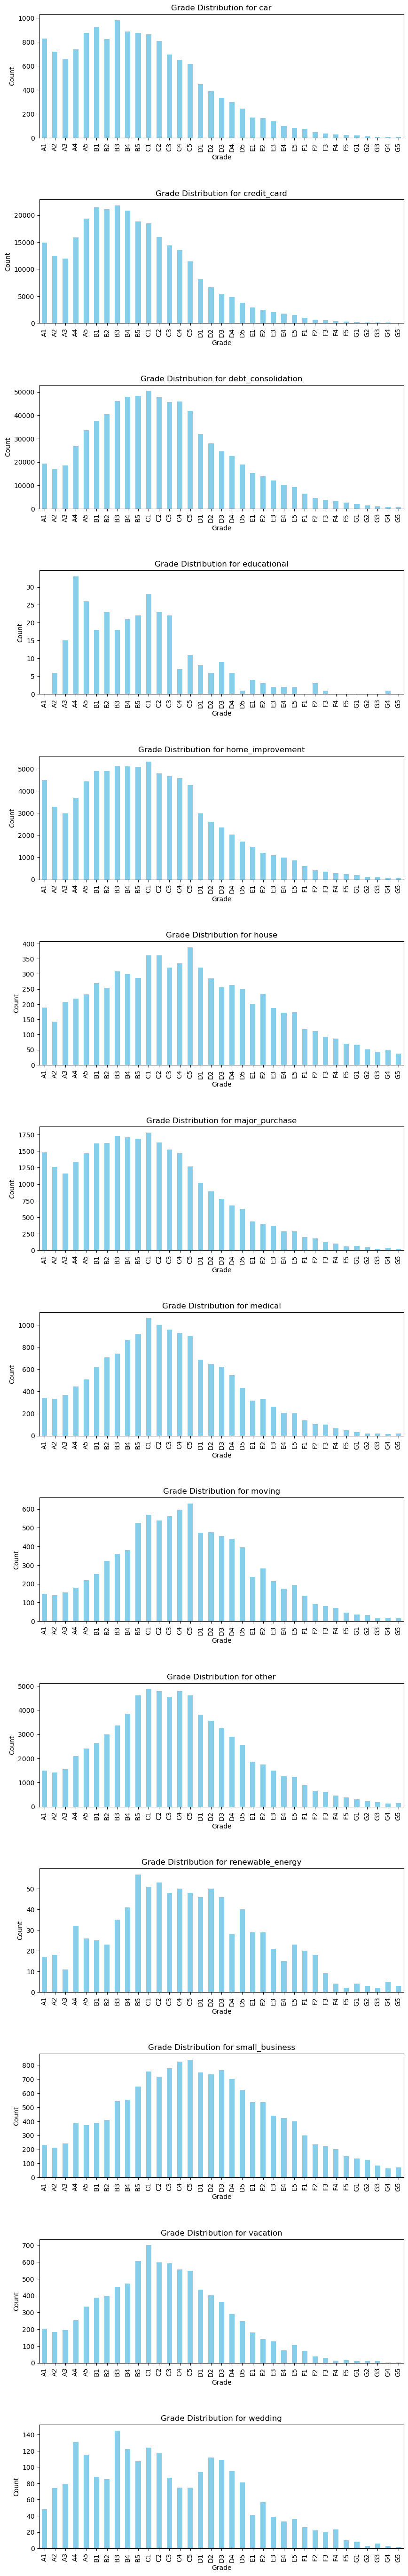

In [40]:
# Group the data by 'purpose' and 'grade' and get the size of each group
purpose_grade_counts = selected_data.groupby(['purpose', 'sub_grade']).size().unstack(fill_value=0)

# Plot histograms
fig, axes = plt.subplots(nrows=len(purpose_grade_counts), ncols=1, figsize=(10, 5 * len(purpose_grade_counts)))
fig.subplots_adjust(hspace=0.5)

for (purpose, data), ax in zip(purpose_grade_counts.iterrows(), axes.flatten()):
    data.plot(kind='bar', ax=ax, title=f'Grade Distribution for {purpose}', color='skyblue')
    ax.set_xlabel('Grade')
    ax.set_ylabel('Count')

plt.show()


In [42]:
# encode categorical variables 
import pandas as pd

encoded_data = pd.get_dummies(selected_data, columns=['home_ownership', 'verification_status', 'purpose', 'application_type'])
print(encoded_data.head())  


    issue_d        id loan_status  loan_amnt  int_rate sub_grade  emp_length  \
0  Dec-2015  68407277  Fully Paid     3600.0     13.99        C4          10   
1  Dec-2015  68355089  Fully Paid    24700.0     11.99        C1          10   
2  Dec-2015  68341763  Fully Paid    20000.0     10.78        B4          10   
4  Dec-2015  68476807  Fully Paid    10400.0     22.45        F1           3   
5  Dec-2015  68426831  Fully Paid    11950.0     13.44        C3           4   

     dti  delinq_2yrs earliest_cr_line  ...  purpose_major_purchase  \
0   5.91          0.0         Aug-2003  ...                   False   
1  16.06          1.0         Dec-1999  ...                   False   
2  10.78          0.0         Aug-2000  ...                   False   
4  25.37          1.0         Jun-1998  ...                    True   
5  10.20          0.0         Oct-1987  ...                   False   

   purpose_medical  purpose_moving  purpose_other  purpose_renewable_energy  \
0            

In [43]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344041 entries, 0 to 2260697
Data columns (total 39 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   issue_d                              1344041 non-null  object 
 1   id                                   1344041 non-null  object 
 2   loan_status                          1344041 non-null  object 
 3   loan_amnt                            1344041 non-null  float64
 4   int_rate                             1344041 non-null  float64
 5   sub_grade                            1344041 non-null  object 
 6   emp_length                           1344041 non-null  int32  
 7   dti                                  1344041 non-null  float64
 8   delinq_2yrs                          1344041 non-null  float64
 9   earliest_cr_line                     1344041 non-null  object 
 10  open_acc                             1344041 non-null  float64
 11  pub

In [48]:
bool_cols = encoded_data.select_dtypes(include='bool').columns
encoded_data[bool_cols] = encoded_data[bool_cols].astype(int)
print(encoded_data.head(30))

     issue_d        id  loan_status  loan_amnt  int_rate sub_grade  \
0   Dec-2015  68407277   Fully Paid     3600.0     13.99        C4   
1   Dec-2015  68355089   Fully Paid    24700.0     11.99        C1   
2   Dec-2015  68341763   Fully Paid    20000.0     10.78        B4   
4   Dec-2015  68476807   Fully Paid    10400.0     22.45        F1   
5   Dec-2015  68426831   Fully Paid    11950.0     13.44        C3   
6   Dec-2015  68476668   Fully Paid    20000.0      9.17        B2   
7   Dec-2015  67275481   Fully Paid    20000.0      8.49        B1   
8   Dec-2015  68466926   Fully Paid    10000.0      6.49        A2   
9   Dec-2015  68616873   Fully Paid     8000.0     11.48        B5   
12  Dec-2015  68338832   Fully Paid     1400.0     12.88        C2   
13  Dec-2015  66624733  Charged Off    18000.0     19.48        E2   
14  Dec-2015  68466961   Fully Paid    28000.0      6.49        A2   
15  Dec-2015  68354783   Fully Paid     9600.0      7.49        A4   
16  Dec-2015  684669

In [49]:
# Replace values in 'loan_status'
encoded_data['loan_status'] = encoded_data['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})

# Convert 'issue_d' to datetime type
encoded_data['issue_d'] = pd.to_datetime(encoded_data['issue_d'], format='%b-%Y')

# Extract year, month, and date
encoded_data['issue_year'] = encoded_data['issue_d'].dt.year
encoded_data['issue_month'] = encoded_data['issue_d'].dt.month
encoded_data['issue_date'] = encoded_data['issue_d'].dt.day

# Display the modified DataFrame to verify the changes
print(encoded_data[['issue_d', 'issue_year', 'issue_month', 'issue_date', 'loan_status']].head())


     issue_d  issue_year  issue_month  issue_date  loan_status
0 2015-12-01        2015           12           1            0
1 2015-12-01        2015           12           1            0
2 2015-12-01        2015           12           1            0
4 2015-12-01        2015           12           1            0
5 2015-12-01        2015           12           1            0


In [53]:
encoded_data['issue_year'].unique()

array([2015, 2018, 2017, 2016, 2014, 2011, 2010, 2009, 2008, 2007, 2013,
       2012])

In [57]:
encoded_data['earliest_cr_line'].unique()

array(['Aug-2003', 'Dec-1999', 'Aug-2000', 'Jun-1998', 'Oct-1987',
       'Jun-1990', 'Feb-1999', 'Apr-2002', 'Nov-1994', 'Jun-1996',
       'Jun-2005', 'May-1984', 'Dec-2001', 'Nov-1993', 'Mar-2005',
       'May-2004', 'Jun-1991', 'May-2000', 'Oct-2011', 'May-1994',
       'Jul-2011', 'May-1991', 'May-2001', 'Jun-2002', 'Dec-1985',
       'Apr-2007', 'Feb-2002', 'Jun-2001', 'Oct-1996', 'Jan-2005',
       'Jul-2001', 'Aug-2004', 'Jun-2007', 'Jul-2004', 'Apr-2001',
       'May-1992', 'Oct-1999', 'Nov-2001', 'Jan-2001', 'Sep-2004',
       'Sep-2006', 'Oct-2002', 'Feb-1990', 'Aug-1987', 'Oct-1998',
       'Aug-2001', 'Feb-2004', 'Aug-2009', 'Jan-1999', 'Jun-2000',
       'Jan-2007', 'Aug-1997', 'Dec-1987', 'Feb-1996', 'Jun-2004',
       'Jun-1995', 'Oct-2004', 'Dec-2002', 'Aug-1986', 'Nov-2002',
       'Oct-2006', 'Sep-2000', 'Feb-2012', 'Apr-2005', 'Sep-1994',
       'Apr-1993', 'Sep-2007', 'Jan-1998', 'May-2008', 'Mar-2001',
       'Apr-1994', 'Apr-2003', 'Jan-2002', 'Jan-2011', 'Nov-20

In [58]:
# Convert 'earliest_cr_line' to datetime format
encoded_data['earliest_cr_line'] = pd.to_datetime(encoded_data['earliest_cr_line'], format='%b-%Y')

# Set the reference date to December 1, 2018
reference_date = pd.Timestamp('2018-12-01')

# Calculate the number of years of credit history until the reference date
encoded_data['years_of_credit_history'] = reference_date.year - encoded_data['earliest_cr_line'].dt.year - ((reference_date.month - encoded_data['earliest_cr_line'].dt.month) < 0)

# Example to display these changes
print(encoded_data[['earliest_cr_line', 'years_of_credit_history']].head())


  earliest_cr_line  years_of_credit_history
0       2003-08-01                       15
1       1999-12-01                       19
2       2000-08-01                       18
4       1998-06-01                       20
5       1987-10-01                       31


In [60]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344041 entries, 0 to 2260697
Data columns (total 43 columns):
 #   Column                               Non-Null Count    Dtype         
---  ------                               --------------    -----         
 0   issue_d                              1344041 non-null  datetime64[ns]
 1   id                                   1344041 non-null  object        
 2   loan_status                          1344041 non-null  int64         
 3   loan_amnt                            1344041 non-null  float64       
 4   int_rate                             1344041 non-null  float64       
 5   sub_grade                            1344041 non-null  object        
 6   emp_length                           1344041 non-null  int32         
 7   dti                                  1344041 non-null  float64       
 8   delinq_2yrs                          1344041 non-null  float64       
 9   earliest_cr_line                     1344041 non-null  datetim

In [61]:
# Drop the specified columns from the DataFrame
encoded_data = encoded_data.drop(columns=['issue_d', 'earliest_cr_line', 'issue_date', 'sub_grade'])

# Display the first few rows of the DataFrame to verify that the columns have been removed
print(encoded_data.head())


         id  loan_status  loan_amnt  int_rate  emp_length    dti  delinq_2yrs  \
0  68407277            0     3600.0     13.99          10   5.91          0.0   
1  68355089            0    24700.0     11.99          10  16.06          1.0   
2  68341763            0    20000.0     10.78          10  10.78          0.0   
4  68476807            0    10400.0     22.45           3  25.37          1.0   
5  68426831            0    11950.0     13.44           4  10.20          0.0   

   open_acc  pub_rec  revol_util  ...  purpose_other  \
0       7.0      0.0        29.7  ...              0   
1      22.0      0.0        19.2  ...              0   
2       6.0      0.0        56.2  ...              0   
4      12.0      0.0        64.5  ...              0   
5       5.0      0.0        68.4  ...              0   

   purpose_renewable_energy  purpose_small_business  purpose_vacation  \
0                         0                       0                 0   
1                         0   

In [62]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344041 entries, 0 to 2260697
Data columns (total 39 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   id                                   1344041 non-null  object 
 1   loan_status                          1344041 non-null  int64  
 2   loan_amnt                            1344041 non-null  float64
 3   int_rate                             1344041 non-null  float64
 4   emp_length                           1344041 non-null  int32  
 5   dti                                  1344041 non-null  float64
 6   delinq_2yrs                          1344041 non-null  float64
 7   open_acc                             1344041 non-null  float64
 8   pub_rec                              1344041 non-null  float64
 9   revol_util                           1344041 non-null  float64
 10  tax_liens                            1344041 non-null  float64
 11  mor

In [64]:
encoded_data.isnull().sum()

id                                     0
loan_status                            0
loan_amnt                              0
int_rate                               0
emp_length                             0
dti                                    0
delinq_2yrs                            0
open_acc                               0
pub_rec                                0
revol_util                             0
tax_liens                              0
mort_acc                               0
fico_score_change                      0
sub_grade_num                          0
home_ownership_MORTGAGE                0
home_ownership_OWN                     0
home_ownership_RENT AND OTHER          0
verification_status_Not Verified       0
verification_status_Source Verified    0
verification_status_Verified           0
purpose_car                            0
purpose_credit_card                    0
purpose_debt_consolidation             0
purpose_educational                    0
purpose_home_imp

In [65]:
# Rename the DataFrame
cleaned_df = encoded_data

# Export the DataFrame to a CSV file
cleaned_df.to_csv('cleaned_df.csv', index=False)  # Set index=False to avoid saving the index as a separate column

print("The DataFrame has been renamed and exported to 'cleaned_df.csv'.")


The DataFrame has been renamed and exported to 'cleaned_df.csv'.


In [2]:
import pandas as pd

# Creating the DataFrame for the performance of each model
model_performance = {
    'Algorithm': [
        'Logistic Regression',
        'Logistic Regression (Lasso)',
        'Random Forest',
        'Tuned Random Forest'
    ],
    'Hyperparameters': [
        'penalty=none, random_state=0',
        'C=0.258, solver=saga, penalty=l1, random_state=0',
        'max_depth=4, n_estimators=1483, criterion=entropy, min_samples_split=0.014, min_samples_leaf=0.000, random_state=0',
        'Parameters tuned via RandomizedSearchCV'
    ],
    'Brier Score': [
        "{:.3f}".format(0.1209),
        "{:.3f}".format(0.1209), # Assuming same score for Logistic Regression (Lasso)
        "{:.3f}".format(0.1008),
        "{:.3f}".format(0.1001)
    ],
    'ROC AUC Score': [
        "{:.3f}".format(0.812),
        "{:.3f}".format(0.812), # Assuming same score for Logistic Regression (Lasso)
        "{:.3f}".format(0.8396),
        "{:.3f}".format(0.8453)
    ]
}

# Convert the data into a Pandas DataFrame
df_model_performance = pd.DataFrame(model_performance)

# Save the DataFrame as an Excel file
excel_file_path = 'C:/Users/user/Desktop/Thesis/model_performance_comparison.xlsx'
df_model_performance.to_excel(excel_file_path, index=False)

df_model_performance


,Algorithm,Hyperparameters,Brier Score,ROC AUC Score
0,Logistic Regression,"penalty=none, random_state=0",0.121,0.812
1,Logistic Regression (Lasso),"C=0.258, solver=saga, penalty=l1, random_state=0",0.121,0.812
2,Random Forest,"max_depth=4, n_estimators=1483, criterion=entr...",0.101,0.840
3,Tuned Random Forest,Parameters tuned via RandomizedSearchCV,0.100,0.845
